<div align='center'>

# PageRank from Scratch — Power Iteration on Graphs

**Author**: Abhishu Oza, Prof. James Abello, Haoyang Zhang

</div>

This assignment introduces the **PageRank algorithm**, originally developed by Google to rank web pages. You will implement the algorithm using NumPy and simulate a random surfer moving from page to page in a directed graph.

You'll learn how to:
- Represent graphs as adjacency matrices
- Handle dangling nodes (pages with no out-links)
- Apply the damping factor and power iteration until convergence

**Libraries to import:**
```python
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
```



```mermaid
graph TB

1.1[Parse Dataset]
1.2[Construct Adjacency Matrix]
1.3[Initialize PageRank Vector]
1.4[Iterative PageRank Computation]
1.5[Plot PagrRank and Degrees]

1.1
1.2
1.3
1.4
1.5

1.1 --> 1.2
1.2 --> 1.3
1.2 --> 1.4
1.3 --> 1.4
1.2 --> 1.5
1.4 --> 1.5
classDef titleClass white-space:nowrap,z-index:2,color:red;
```

``````

# Index
- [Task 1: PageRank Algorithm](#task-1)
  - [Subtask 1.1: Parse Dataset](#task-1-subtask-1)
  - [Subtask 1.2: Construct Adjacency Matrix](#task-1-subtask-2)
  - [Subtask 1.3: Initialize PageRank Vector](#task-1-subtask-3)
  - [Subtask 1.4: Iterative PageRank Computation](#task-1-subtask-4)
  - [Subtask 1.5: Plot PagrRank and Degrees](#task-1-subtask-5)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

### Task 1: PageRank Algorithm <a id='task-1'></a>


The task is to rank pages according to their importance. Roughly speaking, a page would be more important if there were lots of incoming links from other webpages to it. But we need a way to rank all wepages relative to each other. 

Following is the intuition for pagerank. Imagine a random surfer browsing the web. At each step, the surfer either:

- Clicks a link on the current page to go to the next page (with probability d, the damping factor).

- Or jumps to a random page (with probability 1 - d).

Over time, the frequency with which this surfer lands on each page forms the PageRank vector — a probability distribution over nodes (pages).

Markov process is a stochastic process describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. Sometimes, the term Markov process can feel intimidating. To build intuition, let’s work through a tiny example.

Suppose your graph is:
```
1 → 2, 1 → 3  
2 → 3  
3 → 1  
4 → 3
```
Now, a markov process models the web surfing in the following way - a web surfer starts from a random webpage and clicks on any outgoing webpage with equal probability. Each new_pg represents the updated rank for a node, computed by collecting "votes" from incoming neighbors divided by their out-degrees.

Then the pagerank flow equations look like:
```
new_pg_1 = pg_3 / deg_3
new_pg_2 = pg_1 / deg_1
new_pg_3 = pg_1 / deg_1 + pg_2 / deg_2 + pg_4 / deg_4
new_pg_4 = 0  (no incoming links) + teleport factor
```
If we use an adjacency matrix (with 1 value at index [i,j] representing a link from j to i) and normalise our matrix by columns, we get this:

$$
M = 
\begin{bmatrix}
0 & 0 & 1 & 0 \\
0.5 & 0 & 0 & 0 \\
0.5 & 1 & 0 & 1 \\
0 & 0 & 0 & 0
\end{bmatrix}
$$
Now, each new_pg_i is a dot product (sum of products by index entries) of the i_th row vector and the original pg vector (containing all pg values). So we can reformulate the pagerank flow equations using this matrix multiplication: $PR_{new} = M × PR$.


This is the main computational task of PageRank. Our goal is to find a stable vector `pr` such that -

$$\vec{pr} = d \cdot M \vec{pr} + \frac{1 - d}{N} \cdot \vec{1}$$

as this represents the dominant eigenvector of our probability transition matrix.

We calculate this eigenvector via an iterative process as follows (PageRank Update Rule) -
$$\vec{pr_{i+1}} = d \cdot M \vec{pr_i} + \frac{1 - d}{N} \cdot \vec{1}$$

Here:
- $\vec{pr_i}$: the PageRank vector at $i^{th}$ iteration (probability distribution over pages).
- $M$: the normalized transition matrix.
- $d$: damping factor (usually 0.85).
- $N$: number of pages.
- $\vec{1}$: vector with all entries as 1.

We will find an effective `pr` by repeating the updating till $||\vec{pr_{i+1}} - \vec{pr_i}|| < \epsilon$, where we set the convergence threshold $\epsilon$ as a small value.

This task involves building the PageRank algorithm step-by-step using NumPy arrays.
We will define the structure of the graph, transform it into a matrix, apply the damping factor d, and iterate to compute the ranks.


#### Subtask 1.1: Parse Dataset <a id='task-1-subtask-1'></a>

To rank webpages, we scrape the web and find all the incoming and outgoing links to and from all webpages, which would be a graph representation of the web. For our purposes, we parse a given web graph and store the directed edges as an edge list and the nodes as a set.

In the dataset, each line has 2 IDs separated by a tab, and represents a directed edge. The first ID is the "From" node and the second is the "To" node of the directed edge.


In [2]:
def parse_dataset(filepath):
    edge_list = []
    nodes = set()

    with open(filepath, 'r') as f:
        for line in f:
            if not line.strip():
                continue
                
            u, v = map(int, line.strip().split())
            edge_list.append((u, v))
            nodes.add(u)
            nodes.add(v)

    return edge_list, nodes

#### Subtask 1.2: Construct Adjacency Matrix <a id='task-1-subtask-2'></a>

Construct an adjacency matrix A from the dictionary, where  `A[i][j] = 1` if there is an edge from node j to node i. 

Make sure to not get confused between the node IDs and the nodes indices for the matrix. You can make a dictionary using -
```python
ID_to_index = {node_ID: node_index for node_index, node_ID in enumerate(nodes)}
```
This will create a dictionary which takes a node ID and gives an index (`node_index = ID_to_index[node_ID]`), which will simplify a lot of things.

Since we have a large dataset (almost a million nodes or more), we will not be able to directly create an adgacency matrix, because the size will go into Terabytes (try it!)

But we can make an observation about our matrix - most of the values are 0 (most pages dont link to most other pages). Hence we use a sparse matrix representation to store our matrix and perform matrix multiplications efficiently. 

Use `csr_matrix()` for this. You will need to create 3 arrays to pass to it - 
- `data`, which is all ones, and is of size of number of edges.
- `row_index`, which stores all `to_node` indexes for each edge in `edge_list`.
- `col_index` which stores all `from_node` indexes for each edge in `edge_list`. Learn more from the [Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html). 


In [3]:
def create_adjacency_matrix(edge_list, nodes):
    nodes = sorted(nodes)
    N = len(nodes)

    ID_to_index = {node_ID: i for i, node_ID in enumerate(nodes)}

    row_index = []
    col_index = []
    data = []

    for u, v in edge_list:
        row_index.append(ID_to_index[v])   # TO node → row
        col_index.append(ID_to_index[u])   # FROM node → column
        data.append(1)

    A = csr_matrix((data, (row_index, col_index)), shape=(N, N))

    return A, N

#### Subtask 1.3: Initialize PageRank Vector <a id='task-1-subtask-3'></a>

We now create a PageRank vector which stores the frequency with which websites are visited. Initially we consider frequency for all webpages as equal. So initialize PageRank vector `pr_initial` as a uniform distribution over all nodes.
```python
pr_initial # [0.25, 0.25, 0.25, 0.25] if there are 4 webpages
```


In [4]:
def initialize_pagerank(N):
    return np.ones(N) / N

#### Subtask 1.4: Iterative PageRank Computation <a id='task-1-subtask-4'></a>

In our main task description, we show how a normalised matrix is used for iteratively computing the PageRank veector. However, we are unable to build the normalized matrix `M` from `A` because it is inefficient to change specific values in a sparse matrix representation such as `csr_matrix`.

Instead, we rewrite the iteration equation to use `A` directly -

$$\mathbf{PR}_{\text{new}} = d \cdot (A D^{-1} \mathbf{PR} + \frac{\text{dangling\_sum}}{N}) + \frac{1 - d}{N}$$
where 
$$\text{dangling\_sum} = \sum_{i \in dangling}^{} \mathbf{PR}[i]$$

Here $D^{−1}$  normalizes each column of A — so each column becomes a probability distribution for the random walk.

In the function, we will first calculate sums of columns using `out_degree = A.sum(axis=0).A1` and get indices which have sum = 0 using `dangling = (out_degree == 0) ` These are indices of nodes which dont link to any other nodes (hence called dangling nodes)

Then inside the iteration loop, we -
- take the sum of PageRank values of all dangling nodes
- calculate $AD^{-1}\mathbf{PR}$ directly 

using the following -
```python
dangling_sum = pr[dangling].sum()
contrib = A.dot(pr / out_degree)
```
Write the function to repeatedly update the PageRank vector `pr` using the formula and code given above.

Stop and return `pr` when the norm of `(pr_i+1 - pr_i)` is less than epsilon, or when the maximum number of iterations is reached, whichever happens first. 


In [5]:
def power_iteration(A, pr_initial, d=0.85, epsilon=1e-6, max_iter=100):
    pr = pr_initial.copy()
    N = len(pr)

    # column sums = out-degrees
    out_degree = A.sum(axis=0).A1  # convert to 1D array
    dangling = (out_degree == 0)

    for _ in range(max_iter):
        pr_old = pr.copy()

        # Sum of PR for dangling nodes
        dangling_sum = pr_old[dangling].sum()

        # Compute A * (pr_old / out_degree)
        # Safe division: replace 0 with 1 to avoid division error
        divisor = np.where(out_degree == 0, 1, out_degree)
        contrib = A.dot(pr_old / divisor)

        pr = d * (contrib + dangling_sum / N) + (1 - d) / N

        if np.linalg.norm(pr - pr_old) < epsilon:
            break

    return pr

#### Subtask 1.5: Plot PagrRank and Degrees <a id='task-1-subtask-5'></a>

Now let us compare the distribution of pagerank and out-degree. Do the following -
  - Calculate the out-degrees using `degrees = np.array(A.sum(axis=0)).flatten()` 
  - Plot the PageRank distribution and out-degree distribution using `plt.scatter()`. Use logarithmic scale for both axes using `plt.xscale('log')` and `plt.yscale('log')`.


In [8]:
def plot_pr_degree(pr, A):
    # Compute degree (out-degree)
    degrees = np.array(A.sum(axis=0)).flatten()

    # --- PageRank Distribution ---
    pr_counts, pr_bins = np.histogram(pr, bins=100)
    pr_bin_centers = (pr_bins[:-1] + pr_bins[1:]) / 2

    plt.figure()
    plt.scatter(pr_bin_centers, pr_counts, s=10)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('PageRank Distribution')
    plt.xlabel('PageRank')
    plt.ylabel('Frequency')
    plt.show()

    # --- Degree Distribution ---
    deg_counts, deg_bins = np.histogram(degrees, bins=100)
    deg_bin_centers = (deg_bins[:-1] + deg_bins[1:]) / 2

    plt.figure()
    plt.scatter(deg_bin_centers, deg_counts, s=10)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()

    return None

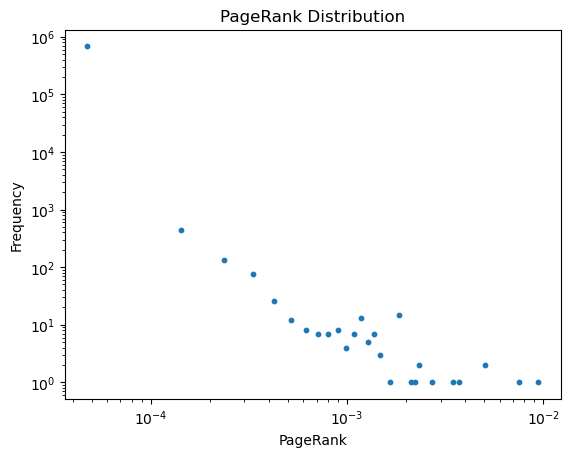

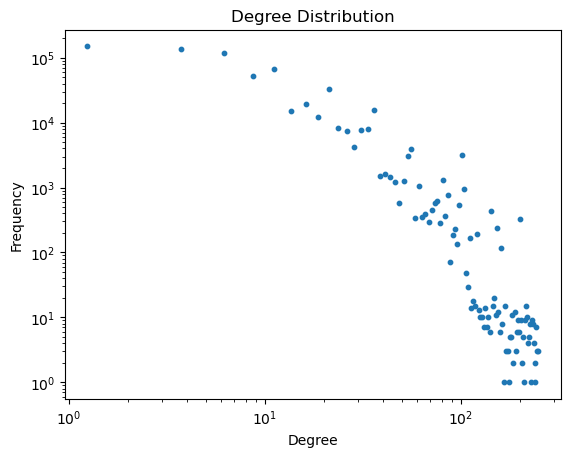

In [9]:
if __name__ == "__main__":
    filepath = "pagerank_web-BerkStan.txt"
    edge_list, nodes = parse_dataset(filepath)
    A, N = create_adjacency_matrix(edge_list, nodes)
    pr_initial = initialize_pagerank(N)
    pr = power_iteration(A, pr_initial=pr_initial)
    plot_pr_degree(pr, A)

## References

- [M4ML - Linear Algebra - 5.7 Introduction to PageRank](https://www.youtube.com/watch?v=urKLHNhUEQ0) Digital Media - Imperial College London (for conceptual understanding)
- [Implementing PageRank Algorithm in Python](https://www.youtube.com/watch?v=gA3nDd_6QJM) Computing For All
